In [58]:
import torch as th

In [136]:
### Scheduler: To control the rate of noise additon

# Noise gaussian stats -> mean=sqrt(1 - beta), variance=beta
def linear_beta_schedule(t):
    scale = 1000 / t
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return th.linspace(beta_start, beta_end, t) 

In [137]:
T = 300 # number of timesteps

betas = linear_beta_schedule(T)

alphas = 1 - betas
alpha_prod = th.cumprod(alphas, 0)
alpha_prod_prev = th.cat([th.tensor([1.0]), alpha_prod[:-1]])

# alpha_prod_sqrt = th.sqrt(alpha_prod)
posterior_var =  betas * (1. - alpha_prod_prev) / (1. - alpha_prod)

def get_noisy_image(x_0, alphas, t):
    alpha_prod = th.cumprod(alphas, 0)
    noise = th.randn_like(x_0)

    alpha_prod_t = alpha_prod[t]
    alpha_prod_prev_t = alpha_prod_prev[t]

    x_t = th.sqrt(alpha_prod_t) * x_0 + th.sqrt(1 - alpha_prod_t) * noise
    return x_t

### DIffusion process

In [138]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
img = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
# image

# Convert PIL image to a torch tensor
from torchvision import transforms

# convenience functions
def image_to_tensor(image, image_size=256):
    transform_to_tensor = transforms.Compose([
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    image_tensor = transform_to_tensor(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Convert torch tensor to RGB image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)  # Reshape tensor to HWC
    tensor = tensor.clamp(0, 1)  # Clamp values to be between 0 and 1
    return tensor.numpy()  # Convert tensor to numpy array



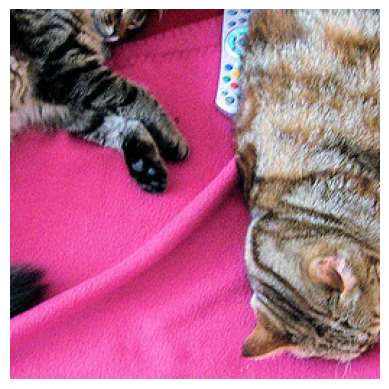

In [268]:
import matplotlib.pyplot as plt

img= image_to_tensor(image)
img = get_noisy_image(image_tensor, alphas, t=0)
    
# Plot the noisy image
img = tensor_to_image(img)
plt.imshow(img)
plt.axis('off')
plt.show()

## Loss function

In [140]:
import torch.nn.functional as F

def loss_fn(predicted_img, actual_noise):
    return F.mse_loss(noise, predicted_noise)


## Sampling a new img

In [306]:
import numpy as np

def p_sample(model_output, x, t):

    # safety checks
    B, C = x.shape[:2]
    print("B, C: ", B, C)

    # assert t.shape == (B,)
    assert model_output.shape == (B, C * 2, *x.shape[2:])

    model_output, model_var_values = th.split(model_output, C, dim=1)

    betas = linear_beta_schedule(t+1)
    alphas = 1 - betas
    
    alpha_prod = th.cumprod(alphas, 0)
    alpha_prod_prev = th.cat([th.tensor([1.0]), alpha_prod[:-1]])
    posterior_var =  betas * (1. - alpha_prod_prev) / (1. - alpha_prod)

    # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
    if len(posterior_var) > 1:
        posterior_var = torch.log(torch.cat([posterior_var[1].unsqueeze(0), posterior_var[1:]]))
    else:
        posterior_var = torch.tensor([])

    # extract values for given timestep
    alpha_prod  = alphas[t]
    alpha_prod_prev= alphas[t-1]
    
    # mean prediction
    # noise_pred = model(x, t, model_kwargs)     
    noise_pred = model_output
    mean_pred =  (x - (betas[t] * noise_pred / th.sqrt(1. - alpha_prod))) * 1 / th.sqrt(alphas[t])

    # var prediction
    # var_fixed = betas[t] * th.eye(x.size(0)) 
    min_log = posterior_var[t]
    max_log = torch.log(betas[t])

    # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    var_pred = th.exp(model_log_variance)

    x_prev = mean_pred + var_pred
    return x_prev 


In [307]:
z = th.randn(2,4,32,32)
n_sampling_steps = 5

# start with pure noise
x = th.randn_like(z)  # Added batch dimension
print("x: ", x.shape)

# time indices in reverse
indices = list(range(1, n_sampling_steps + 1))[::-1]

for i in indices:
    t = th.tensor([i] * x.shape[0], device="cpu") 

    # model_output = model.forward_with_cfg(x, t, y, cfg_scale)
    model_output = th.randn(2,8,32,32)

    x = p_sample(model_output, x, i) 

x:  torch.Size([2, 4, 32, 32])
B, C:  2 4
B, C:  2 4
B, C:  2 4
B, C:  2 4
B, C:  2 4
